In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def conv_forward(A_prev, W, b, activation, padding="same", stride=(1, 1)):
    """
    Perform Froward propagation over a convolution layer.

    A_prev is a numpy.ndarray of shape (m, h_prev, w_prev, c_prev)
        containing the output of the previous layer
        m is the number of examples
        h_prev is the height of the previous layer
        w_prev is the width of the previous layer
        c_prev is the number of channels in the previous layer

    W is a numpy.ndarray of shape (kh, kw, c_prev, c_new)
    containing the kernels for the convolution
        kh is the filter height
        kw is the filter width
        c_prev is the number of channels in the previous layer
        c_new is the number of channels in the output

    b is a numpy.ndarray of shape (1, 1, 1, c_new) containing
    the biases applied to the convolution

    activation is an activation function applied to the convolution

    padding is a string that is either same or valid,
    indicating the type of padding used

    stride is a tuple of (sh, sw) containing the strides for the convolution
        sh is the stride for the height
        sw is the stride for the width
    """
    m, h, w, _ = A_prev.shape
    kh, kw, _, nc = W.shape
    sh, sw = stride
    if padding == 'valid':
        ph, pw = 0, 0
    else:
        ph = int(np.ceil((sh*(h-1)-h+kh)/2))
        pw = int(np.ceil((sw*(w-1)-w+kw)/2))
    oh = int((h+2*pw-kh)/sh+1)
    ow = int((w+2*pw-kw)/sw+1)
    npad = ((0, 0), (ph, ph), (pw, pw), (0, 0))
    A_pad = np.pad(A_prev, pad_width=npad, mode='constant')
    output = np.zeros((m, oh, ow, nc))
    for k in range(nc):
        filterk = W[:, :, :, k]
        for i in range(oh):
            for j in range(ow):
                x = i * sh
                y = j * sw
                to_conv = A_pad[:, x:x+kh, y:y+kw, :]
                output[:, i, j, k] = np.tensordot(to_conv, filterk, axes=3)

    output = activation(output + b)
    return output




In [ ]:

np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
m, h, w = X_train.shape
X_train_c = X_train.reshape((-1, h, w, 1))

W = np.random.randn(3, 3, 1, 2)
b = np.random.randn(1, 1, 1, 2)

def relu(Z):
    return np.maximum(Z, 0)

plt.imshow(X_train[0])
plt.show()
A = conv_forward(X_train_c, W, b, relu, padding='same')
print(A.shape)
plt.imshow(A[0, :, :, 0])
plt.show()
plt.imshow(A[0, :, :, 1])
plt.show()

In [ ]:

def pool_forward(A_prev, kernel_shape, stride=(1, 1), mode='max'):
    """
    Perform forward propagation.

    A_prev is a numpy.ndarray of shape (m, h_prev, w_prev, c_prev)
    containing the output of the previous layer
        m is the number of examples
        h_prev is the height of the previous layer
        w_prev is the width of the previous layer
        c_prev is the number of channels in the previous layer
    kernel_shape is a tuple of (kh, kw) containing the
    size of the kernel for the pooling
        kh is the kernel height
        kw is the kernel width
    stride is a tuple of (sh, sw) containing the strides for the pooling
        sh is the stride for the height
        sw is the stride for the width
    mode is a string containing either max or avg, indicating whether
    to perform maximum or average pooling, respectively
    """
    kh, kw = kernel_shape
    sh, sw = stride
    m, h, w, c = A_prev.shape
    if mode == 'max':
        func = np.max
    elif mode == 'avg':
        func = np.average

    oh = int((h-kh)/sh+1)
    ow = int((w-kw)/sw+1)
    output = np.zeros((m, oh, ow, c))
    for i in range(0, oh):
        x = i * sh
        for j in range(0, ow):
            y = j * sw
            output[:, i, j, :] = func(A_prev[:, x:x+kh, y:y+kw], axis=(1, 2))

    return output

In [ ]:
np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
m, h, w = X_train.shape
X_train_a = X_train.reshape((-1, h, w, 1))
X_train_b = 1 - X_train_a
X_train_c = np.concatenate((X_train_a, X_train_b), axis=3)

print(X_train_c.shape)
plt.imshow(X_train_c[0, :, :, 0])
plt.show()
plt.imshow(X_train_c[0, :, :, 1])
plt.show()
A = pool_forward(X_train_c, (2, 2), stride=(2, 2))
print(A.shape)
plt.imshow(A[0, :, :, 0])
plt.show()
plt.imshow(A[0, :, :, 1])
plt.show()


In [ ]:

def conv_backward(dZ, A_prev, W, b, padding="same", stride=(1, 1)):
    """Backward propagation for Conv layer."""
    m, prev_h, prev_w, _ = A_prev.shape
    m, new_h, new_w, new_c = dZ.shape
    sh, sw = stride
    kh, kw, _, new_c = W.shape
    if padding == 'valid':
        ph, pw = 0, 0
    else:
        ph = int(np.ceil((sh*(prev_h-1)-prev_h+kh)/2))
        pw = int(np.ceil((sw*(prev_w-1)-prev_w+kw)/2))
    npad = ((0, 0), (ph, ph), (pw, pw), (0, 0))
    A_prev = np.pad(A_prev, pad_width=npad, mode='constant')
    dw = np.zeros_like(W)
    dA = np.zeros_like(A_prev)
    db = np.sum(dZ, axis=(0, 1, 2), keepdims=True)
    for img in range(m):
        for h in range(new_h):
            for w in range(new_w):
                x = h * sh
                y = w * sw
                for f in range(new_c):
                    filt = W[:, :, :, f]
                    dz = dZ[img, h, w, f]
                    slice_A = A_prev[img, x:x+kh, y:y+kw,:]
                    dw[:, :, :, f] += slice_A * dz
                    dA[img, x:x+kh, y:y+kw,:] += dz * filt
                    
    if padding == 'same':
        dA = dA[:, ph:-ph, pw:-pw, :]
    return dA, dw, db


In [ ]:
np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
_, h, w = X_train.shape
X_train_c = X_train[:10].reshape((-1, h, w, 1))

W = np.random.randn(3, 3, 1, 2)
b = np.random.randn(1, 1, 1, 2)

dZ = np.random.randn(10, h - 2, w - 2, 2)
print(conv_backward(dZ, X_train_c, W, b, padding="valid"))

In [ ]:

def pool_backward(dA, A_prev, kernel_shape, stride=(1, 1), mode='max'):
    """Performs back propagation over a pooling layer of a neural network."""
    kh, kw = kernel_shape
    sh, sw = stride
    # m, h, w, c = A_prev.shape
    m, n_h, n_w, n_c = dA.shape
    dA_prev = np.zeros_like(A_prev)

    for img in range(m):
        for i in range(n_h):
            for j in range(n_w):
                x = i * sh
                y = j * sw
                for k in range(n_c):
                    if mode == 'max':
                        a_prev_s = A_prev[img, x:x+kh, y:y+kw, k]
                        mask = (a_prev_s == np.max(a_prev_s))
                        dA_prev[img, x:x+kh, y:y+kw, k] += mask*dA[img, i, j, k]
                    else:
                        average_dA = dA[img,i,j,k]/(n_h*n_w)
                        mask = np.ones((kh, kw))
                        dA_prev[img, x:x+kh, y:y+kw, k] += mask*average_dA

    return dA_prev

In [ ]:
np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
_, h, w = X_train.shape
X_train_a = X_train[:10].reshape((-1, h, w, 1))
X_train_b = 1 - X_train_a
X_train_c = np.concatenate((X_train_a, X_train_b), axis=3)

dA = np.random.randn(10, h // 3, w // 3, 2)
print(pool_backward(dA, X_train_c, (3, 3), stride=(3, 3)))

In [4]:

import tensorflow.compat.v1 as tf


def create_pooling_layer(prev, size, stride):
    """Create pooling layer."""
    layer = tf.layers.MaxPooling2D(size, stride)
    return layer(prev)


def create_conv_layer(prev, size, padding, stride):
    """Create Conv layer."""
    weight = tf.keras.initializers.VarianceScaling(scale=2.0)
    layer = tf.layers.Conv2D(filters=size[2],
                             kernel_size=(size[0], size[1]), strides=stride,
                             padding=padding, kernel_initializer=weight)
    return layer(prev)


def create_normal_layer(prev, n, activation):
    """Create tensorflow layer."""
    weight = tf.keras.initializers.VarianceScaling(scale=2.0)
    layer = tf.layers.Dense(n, activation=activation, name="layer",
                                  kernel_initializer=weight)
    return layer(prev)


def conv_forward_prop(x, conv_sizes=[], padding=[], pool_sizes=[], strides=[]):
    """Convolution forward propagation."""
    xi = None
    for conv, pad, pool, stride in zip(conv_sizes, padding,
                                       pool_sizes, strides):
        xi = create_conv_layer(x, conv, pad, stride[0])
        xi = create_pooling_layer(xi, pool, stride[1])
        x = xi
    return xi


def forward_prop(x, layer_sizes=[], activations=[]):
    """Forward propagation."""
    xi = None
    for layer, activation in zip(layer_sizes, activations):
        xi = create_normal_layer(x, layer, activation)
        x = xi
    return xi


def calculate_loss(y, y_pred):
    """Calculate cross entropy loss."""
    return tf.losses.softmax_cross_entropy(y, y_pred)


def calculate_accuracy(y, y_pred):
    """Accuracy of prediction."""
    y = tf.argmax(y, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    correct = tf.equal(y, y_pred)
    return tf.reduce_mean(tf.cast(correct, dtype='float'))


def create_train_op(loss):
    """Create training operation."""
    train = tf.train.AdamOptimizer()
    grads = train.compute_gradients(loss)
    return train.apply_gradients(grads)


def lenet5(x, y):
    """
    Build a modified LeNet-5 model for number recognition.

    x is a tf.placeholder of shape (m, 28, 28, 1)
    containing the input images for the network
        m is the number of images
    y is a tf.placeholder of shape (m, 10)
    containing the one-hot labels for the network
    """
    conv_sizes = [(5, 5, 6), (5, 5, 16)]
    pool_sizes = [(2, 2), (2, 2)]
    strides = [((1, 1), (2, 2)), ((1, 1), (2, 2))]
    paddings = ['same', 'valid']
    layer_sizes = [120, 84, 10]
    activations = ['relu', 'relu', 'softmax']
    y_conv = conv_forward_prop(x, conv_sizes, paddings, pool_sizes, strides)
    x_flat = tf.layers.Flatten()(y_conv)
    y_pred = forward_prop(x_flat, layer_sizes, activations)
    accuracy = calculate_accuracy(y, y_pred)
    loss = calculate_loss(y, y_pred)
    train_op = create_train_op(loss)

    return y_pred, train_op, loss, accuracy


In [2]:
import matplotlib.pyplot as plt
import numpy as np

After 0 epochs: 2.3022689819335938 cost, 0.13001999258995056 accuracy, 2.298532485961914 validation cost, 0.13019999861717224 validation accuracy
After 1 epochs: 1.5880002975463867 cost, 0.872439980506897 accuracy, 1.5809589624404907 validation cost, 0.8799999952316284 validation accuracy
After 2 epochs: 1.581747055053711 cost, 0.8787000179290771 accuracy, 1.5787707567214966 validation cost, 0.882099986076355 validation accuracy
After 3 epochs: 1.5814365148544312 cost, 0.8786799907684326 accuracy, 1.5797611474990845 validation cost, 0.880299985408783 validation accuracy
After 4 epochs: 1.487547516822815 cost, 0.9736199975013733 accuracy, 1.4878511428833008 validation cost, 0.9739999771118164 validation accuracy
After 5 epochs: 1.4839224815368652 cost, 0.9773399829864502 accuracy, 1.4869685173034668 validation cost, 0.9742000102996826 validation accuracy
After 6 epochs: 1.4798390865325928 cost, 0.981440007686615 accuracy, 1.482581615447998 validation cost, 0.9786999821662903 validation 

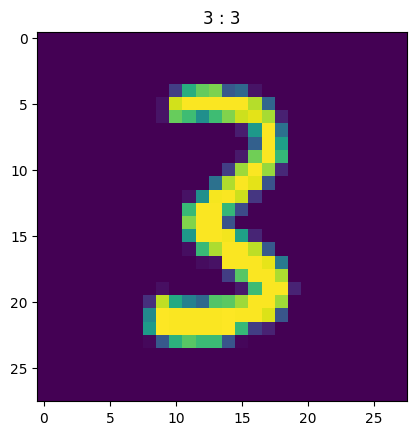

In [5]:
tf.disable_eager_execution()

np.random.seed(0)
tf.set_random_seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
Y_train = lib['Y_train']
X_valid = lib['X_valid']
Y_valid = lib['Y_valid']
m, h, w = X_train.shape
X_train_c = X_train.reshape((-1, h, w, 1))
X_valid_c = X_valid.reshape((-1, h, w, 1))
x = tf.placeholder(tf.float32, (None, h, w, 1))
y = tf.placeholder(tf.int32, (None,))
y_oh = tf.one_hot(y, 10)
y_pred, train_op, loss, acc = lenet5(x, y_oh)
batch_size = 32
epochs = 10
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        cost, accuracy = sess.run((loss, acc), feed_dict={x:X_train_c, y:Y_train})
        cost_valid, accuracy_valid = sess.run((loss, acc), feed_dict={x:X_valid_c, y:Y_valid})
        print("After {} epochs: {} cost, {} accuracy, {} validation cost, {} validation accuracy".format(epoch, cost, accuracy, cost_valid, accuracy_valid))
        p = np.random.permutation(m)
        X_shuffle = X_train_c[p]
        Y_shuffle = Y_train[p]
        for i in range(0, m, batch_size):
            X_batch = X_shuffle[i:i+batch_size]
            Y_batch = Y_shuffle[i:i+batch_size]
            sess.run(train_op, feed_dict={x:X_batch, y:Y_batch})
    cost, accuracy = sess.run((loss, acc), feed_dict={x:X_train_c, y:Y_train})
    cost_valid, accuracy_valid = sess.run((loss, acc), feed_dict={x:X_valid_c, y:Y_valid})
    print("After {} epochs: {} cost, {} accuracy, {} validation cost, {} validation accuracy".format(epochs, cost, accuracy, cost_valid, accuracy_valid))
    Y_pred = sess.run(y_pred, feed_dict={x:X_valid_c, y:Y_valid})
    print(Y_pred[0])
    Y_pred = np.argmax(Y_pred, 1)
    plt.imshow(X_valid[0])
    plt.title(str(Y_valid[0]) + ' : ' + str(Y_pred[0]))
    plt.show()